In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import random


In [ ]:
import os

base_path = ""
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
valid_path = os.path.join(base_path, "Validation")

#image classes
image_classes = os.listdir("")
image_classes

['Non Defective', 'Defective']

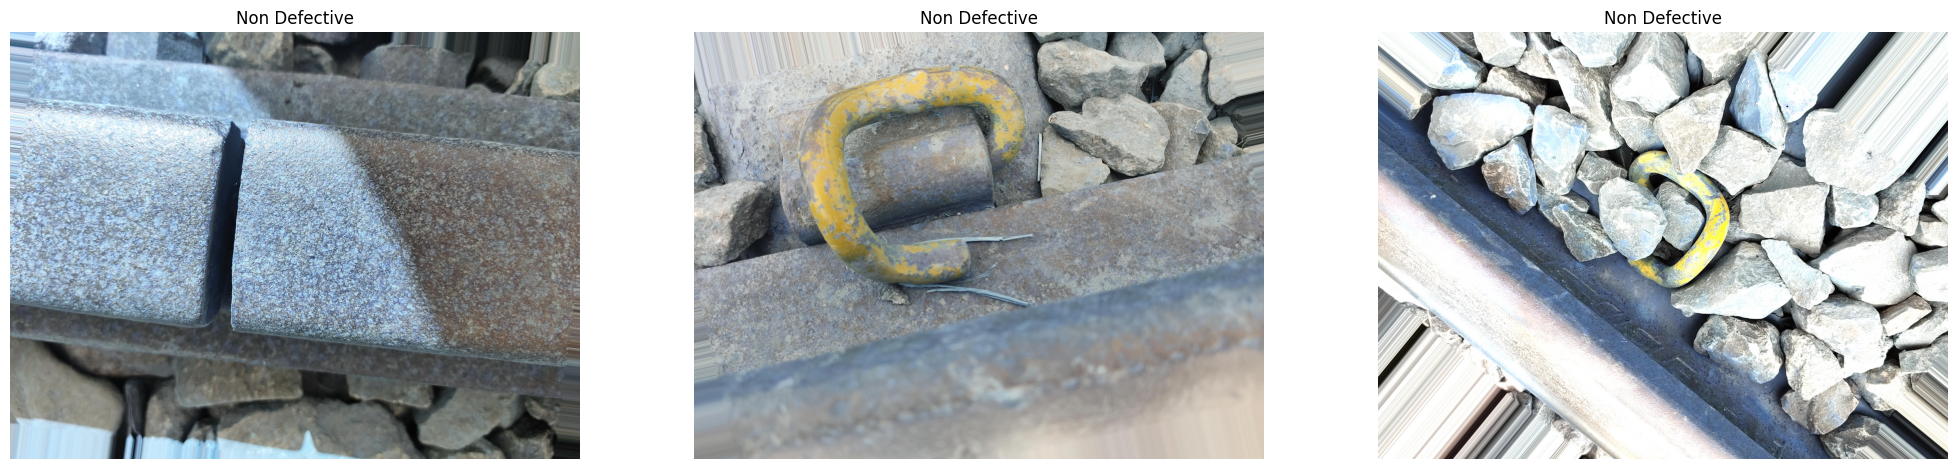

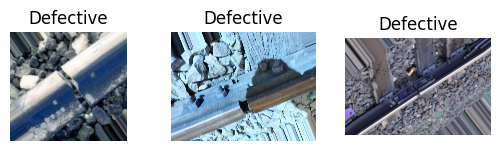

In [3]:
from PIL import Image
def plot_images(image_classes):
    plt.figure(figsize = (25, 25))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + "/" + category
        image_in_folder = os.listdir(image_path)
        
        for j in range(3):
            omage = image_in_folder[j]
            omage_path = image_path + "/" + omage
        
            img = image.load_img(omage_path)
            img_array = image.img_to_array(img) / 255
            
            plt.subplot(3,3, j+1)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis("off")
        plt.show()

plot_images(image_classes)

In [13]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
train_data_noaug = image_generator.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = "categorical")

Found 1540 images belonging to 2 classes.


In [15]:
test_data = image_generator.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                batch_size = 1,
                                                class_mode = "categorical")

Found 220 images belonging to 2 classes.


In [16]:
valid_data = image_generator.flow_from_directory(valid_path,
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = "categorical")

Found 438 images belonging to 2 classes.


In [17]:
from tensorflow.keras.models import load_model
model_noaug = load_model("EfficientNetV2B0_Finetuned.keras", compile=False)


Found 220 images belonging to 2 classes.


/home/jasser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


📊 Classification Report:

               precision    recall  f1-score   support

    Defective       0.97      0.91      0.94       110
Non Defective       0.91      0.97      0.94       110

     accuracy                           0.94       220
    macro avg       0.94      0.94      0.94       220
 weighted avg       0.94      0.94      0.94       220



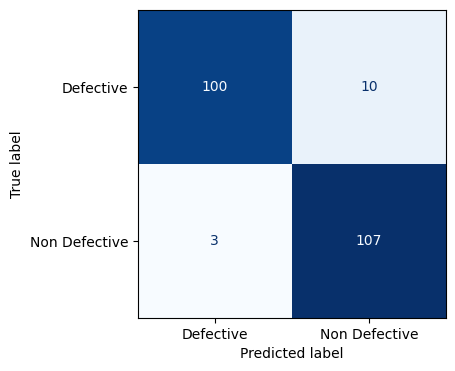


================= CLASSIFICATION MATRIX =================
Predicted →
             |  Defective   Non Defective
-----------------------------------------
Actual Defective |         100          10
Actual Non Defective |           3         107


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

test_data = image_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

test_data.reset()

pred_probs = model_noaug.predict(test_data, verbose=0)

y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

target_names = list(test_data.class_indices.keys())
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names
)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.show()

print("\n================= CLASSIFICATION MATRIX =================")
print("Predicted →")
header = "             |  " + "  ".join([f"{name:10s}" for name in target_names])
print(header)
print("-" * len(header))

for i, cls_name in enumerate(target_names):
    row = f"Actual {cls_name:8s} |  " + "  ".join([f"{cm[i][j]:10d}" for j in range(len(target_names))])
    print(row)

print("=" * len(header))



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [19]:
for layer in model_noaug.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("Last Conv Layer:", layer.name)
        break


Last Conv Layer: top_conv


/home/jasser/.local/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


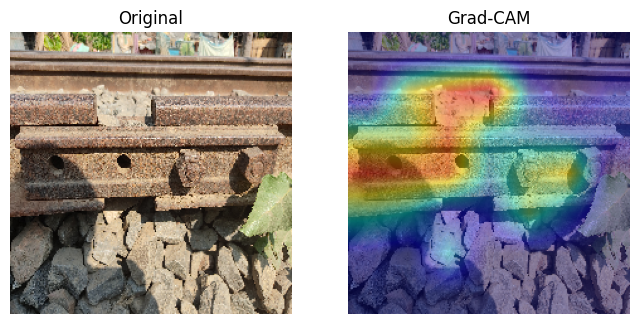

In [ ]:
img_path = test_data.filepaths[14]  # example

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, model_noaug, last_conv_layer_name="top_conv")

heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 
                                   0.6, heatmap, 0.4, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()
